In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

In [6]:
# Load the model
model = tf.keras.models.load_model(r'C:\Users\Januka\OneDrive - University of Moratuwa\Github\image_anomaly_detection_using_autoencoders\cell_anomaly_detection.h5')
encoder_model = tf.keras.models.load_model(r'C:\Users\Januka\OneDrive - University of Moratuwa\Github\image_anomaly_detection_using_autoencoders\cell_anomaly_detection_encoder.h5')

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
encoder_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [49]:
# Size of our input images
SIZE = 128
# Batch size for data generators
batch_size = 64

# Data generators setup
datagen = ImageDataGenerator(rescale=1./255)
train_dir = r'C:\Users\Januka\Documents\data\cell_images2\uninfected_train'

In [51]:
# Train data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
)

Found 13338 images belonging to 1 classes.


In [52]:
#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

C:\Users\Januka\AppData\Local\Temp\ipykernel_14300\3236108514.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


In [53]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500  # Set this value based on the above exercise
    reconstruction_error_threshold = 0.004  # Set this value based on the above exercise
    img = Image.open(img_path)
    img = np.array(img.resize((128, 128), Image.Resampling.LANCZOS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :, :, :]
    encoded_img = encoder_model.predict([[img]])
    out_vector_shape = encoder_model.layers[-1].output_shape[1:]
    encoded_img = np.reshape(encoded_img, (-1, np.prod(out_vector_shape)))  # Reshape to 2D
    kde.fit(encoded_img)
    density = kde.score_samples(encoded_img)[0]

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction], [[img]], batch_size=1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
    else:
        print("The image is NOT an anomaly")


In [54]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
import random
para_file_paths = glob.glob(r'C:\Users\Januka\Documents\data\cell_images2\Parasitized\images\*')
uninfected_file_paths = glob.glob(r'C:\Users\Januka\Documents\data\cell_images2\uninfected_train\images\*')

1/1 [==============================] - 0s 51ms/step - loss: 0.0039 - mse: 0.0039
The image is NOT an anomaly


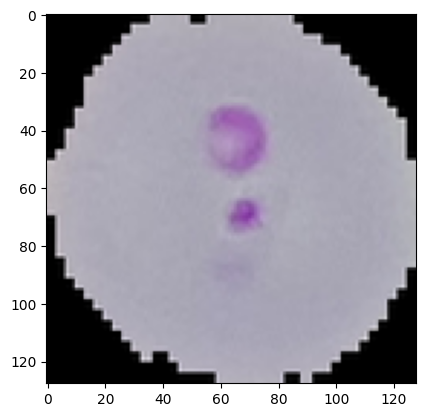

In [67]:
#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

1/1 [==============================] - 0s 48ms/step - loss: 0.0034 - mse: 0.0034
The image is NOT an anomaly


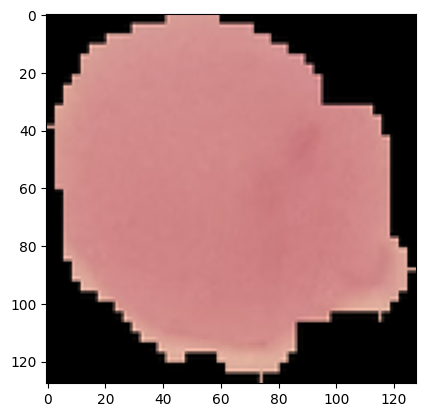

In [56]:
#Good/normal image verification
num=random.randint(0,len(uninfected_file_paths)-1)
check_anomaly(uninfected_file_paths[num])